<a href="https://colab.research.google.com/github/Charan6924/Deep-Learning/blob/main/SuperResolutionBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pyarrow.parquet as pq
from torch.utils.data import IterableDataset, DataLoader
from google.colab import drive
import glob
import os
import torch.optim as optim
import random
import gc
import time

In [ ]:
all_files = [
    '/content/data/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272_LR.parquet',
    '/content/data/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540_LR.parquet',
    '/content/data/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494_LR.parquet',]

In [ ]:

class JetImageDataset(IterableDataset):
    def __init__(
        self,
        parquet_files,
        split="train",
        train_ratio=0.8,
        chunk_size=512,
        normalize=True,
        seed=42,
    ):
        super().__init__()
        self.parquet_files = parquet_files
        self.split = split
        self.train_ratio = train_ratio
        self.chunk_size = chunk_size
        self.normalize = normalize
        self.seed = seed

        self.lr_col = "X_jets_LR"
        self.hr_col = "X_jets"

        self.lr_shape = (3, 64, 64)
        self.hr_shape = (3, 125, 125)

        assert split in {"train", "val"}

    def _get_worker_files(self):
        worker = get_worker_info()
        if worker is None:
            return self.parquet_files
        return self.parquet_files[worker.id :: worker.num_workers]
    def _convert_chunk(self, batch):
      lr_col = batch.column(self.lr_col).to_numpy(zero_copy_only=False)
      hr_col = batch.column(self.hr_col).to_numpy(zero_copy_only=False)

      lr_out = np.empty((len(lr_col), 3, 64, 64), dtype=np.float32)
      hr_out = np.empty((len(hr_col), 3, 125, 125), dtype=np.float32)

      for i in range(len(lr_col)):
          # LR
          for c in range(3):
              lr_out[i, c] = np.stack(lr_col[i][c], axis=0)

          # HR
          for c in range(3):
              hr_out[i, c] = np.stack(hr_col[i][c], axis=0)

      lr = torch.from_numpy(lr_out)
      hr = torch.from_numpy(hr_out)

      if self.normalize:
          lr /= 255.0
          hr /= 255.0

      return lr, hr
    def __iter__(self):
        rng = np.random.default_rng(self.seed)
        files = self._get_worker_files()

        for file_path in files:
            parquet = pq.ParquetFile(file_path)

            for batch in parquet.iter_batches(
                batch_size=self.chunk_size,
                columns=[self.lr_col, self.hr_col],
            ):
                lr, hr = self._convert_chunk(batch)
                mask = rng.random(len(lr)) < self.train_ratio
                if self.split == "train":
                    idxs = torch.where(torch.from_numpy(mask))[0]
                else:
                    idxs = torch.where(torch.from_numpy(~mask))[0]

                for i in idxs:
                    yield lr[i], hr[i]


In [ ]:
def collate_fn(batch):
    lr_batch = torch.stack([item[0] for item in batch])
    hr_batch = torch.stack([item[1] for item in batch])
    return lr_batch, hr_batch

In [ ]:
train_dataset = JetImageDataset(
    parquet_files=all_files,
    split='train',
    train_ratio=0.8,
    chunk_size=512,
    normalize=False
)

val_dataset = JetImageDataset(
    parquet_files=all_files,
    split='val',
    train_ratio=0.8,
    chunk_size=512,
    normalize=False
)

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, pin_memory=True,prefetch_factor = 2,persistent_workers=True,  )
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=True, prefetch_factor = 2,persistent_workers=True,)


In [ ]:
import time

t0 = time.time()
for i, (lr, hr) in enumerate(train_dataset):
    if i == 100:
        break
print("100 batches took:", time.time() - t0)

100 batches took: 1.698882818222046


In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (scale_factor ** 2),
                             kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention = self.avg_pool(x)
        attention = self.fc(attention)
        return x * attention

In [ ]:
class ResBlock(nn.Module):
  def __init__(self,channels):
    super(ResBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU(num_parameters=channels)
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)

  def forward(self,x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + 0.1 * residual

In [ ]:
class Generator(nn.Module):
    def __init__(self, resblocks=16, channels=3, base_channels=64, use_attention=True):
        super(Generator, self).__init__()
        self.conv_input = nn.Sequential(
            nn.Conv2d(channels, base_channels, kernel_size=9, padding=4),
            nn.PReLU())
        res_blocks = []
        for i in range(resblocks):
            res_blocks.append(ResBlock(base_channels))
            if use_attention and i in {7, 15}:  # only 2 attention
              res_blocks.append(ChannelAttention(base_channels))

        self.resblocks = nn.Sequential(*res_blocks)
        self.conv_mid = nn.Sequential(
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels)
        )
        self.upsample1 = UpsampleBlock(base_channels, base_channels)  # 64→128
        self.conv_output = nn.Sequential(
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(base_channels, channels, kernel_size=9, padding=4)
        )
        self.final_resize = nn.Upsample(size=(125, 125), mode='bilinear', align_corners=False)

    def forward(self, x):
        x1 = self.conv_input(x)
        x2 = self.resblocks(x1)
        x3 = self.conv_mid(x2)
        x_mid = x1 + x3
        x_up = self.upsample1(x_mid)
        out = self.conv_output(x_up)
        out = self.final_resize(out)

        return out

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.MSELoss()
EPOCHS = 20
PATIENCE = 3
best_val_loss = float('inf')
patience_counter = 0
train_lossi = []
val_lossi = []
scaler = torch.amp.GradScaler(device='cuda')
checkpoint = torch.load("/content/sr_model_best.pth", map_location=device)
new_state_dict = {}
for k, v in checkpoint.items():
    if k.startswith("_orig_mod."):
        new_key = k[len("_orig_mod."):]
    else:
        new_key = k
    new_state_dict[new_key] = v
model = Generator().to(device)
model.load_state_dict(new_state_dict)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
model = torch.compile(model)

print("Checkpoint loaded, model ready for training!")


Checkpoint loaded, model ready for training!


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0
    train_count = 0
    epoch_start = time.time()

    for i, (lr, hr) in enumerate(train_loader):
        lr = lr.to(device, non_blocking=True)
        hr = hr.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(lr)
            loss = criterion(outputs, hr)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        train_lossi.append(loss.item())

        running_train_loss += loss.item()
        train_count += 1

        if i % 500 == 0:
            print(f"   Ep {epoch+1} | Step {i} | Train Loss: {loss.item():.6f}")

    avg_train_loss = running_train_loss / train_count

    model.eval()
    running_val_loss = 0.0
    val_count = 0

    with torch.no_grad(), torch.amp.autocast(device_type='cuda', dtype=torch.float16):
        for val_lr, val_hr in val_loader:
            val_lr, val_hr = val_lr.to(device), val_hr.to(device)
            val_outputs = model(val_lr)
            v_loss = criterion(val_outputs, val_hr)
            running_val_loss += v_loss.item()
            val_count += 1

    avg_val_loss = running_val_loss / val_count
    val_lossi.append(avg_val_loss)
    scheduler.step(avg_val_loss)
    epoch_time = time.time() - epoch_start

    print(f"Epoch {epoch+1} Summary: Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Time: {epoch_time:.1f}s")
    if avg_val_loss < best_val_loss:
        print(f"IMPROVEMENT! ({best_val_loss:.6f} -> {avg_val_loss:.6f})")
        best_val_loss = avg_val_loss
        patience_counter = 0
        save_file = f"/content/sr_model_best.pth"
        torch.save(model.state_dict(), save_file)
        print(f"Saved Best Model to {save_file}")

    else:
        print(f"No Improvement. (Best Val was: {best_val_loss:.6f})")
        patience_counter += 1
        print(f"Patience: {patience_counter}/{PATIENCE}")

        if patience_counter >= PATIENCE:
            print(f"EARLY STOPPING TRIGGERED")
            break
    gc.collect()
    torch.cuda.empty_cache()

   Ep 1 | Step 0 | Train Loss: 0.027006
   Ep 1 | Step 500 | Train Loss: 0.038673
   Ep 1 | Step 1000 | Train Loss: 0.033795
   Ep 1 | Step 1500 | Train Loss: 0.027106
Epoch 1 Summary: Train Loss: 1.262650 | Val Loss: 0.138972 | Time: 763.7s
IMPROVEMENT! (inf -> 0.138972)
Saved Best Model to /content/sr_model_best.pth
   Ep 2 | Step 0 | Train Loss: 0.026749
   Ep 2 | Step 500 | Train Loss: 0.037857
   Ep 2 | Step 1000 | Train Loss: 0.033637
   Ep 2 | Step 1500 | Train Loss: 0.027019
Epoch 2 Summary: Train Loss: 1.260597 | Val Loss: 0.139114 | Time: 734.9s
No Improvement. (Best Val was: 0.138972)
Patience: 1/3
   Ep 3 | Step 0 | Train Loss: 0.026654
   Ep 3 | Step 500 | Train Loss: 0.037490
   Ep 3 | Step 1000 | Train Loss: 0.033652
   Ep 3 | Step 1500 | Train Loss: 0.026988
Epoch 3 Summary: Train Loss: 1.237406 | Val Loss: 0.138705 | Time: 734.8s
IMPROVEMENT! (0.138972 -> 0.138705)
Saved Best Model to /content/sr_model_best.pth
   Ep 4 | Step 0 | Train Loss: 0.026596
   Ep 4 | Step 500

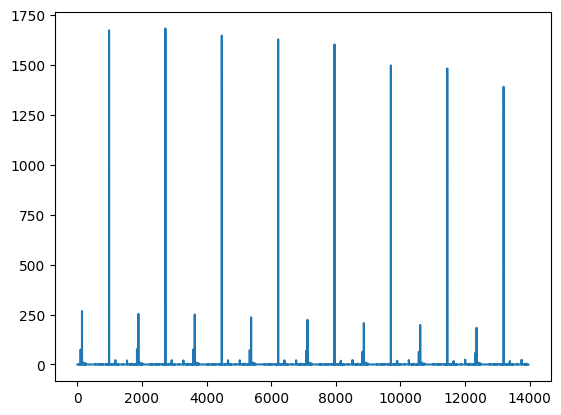

In [ ]:
plt.plot(train_lossi, label='train_loss')
plt.show()

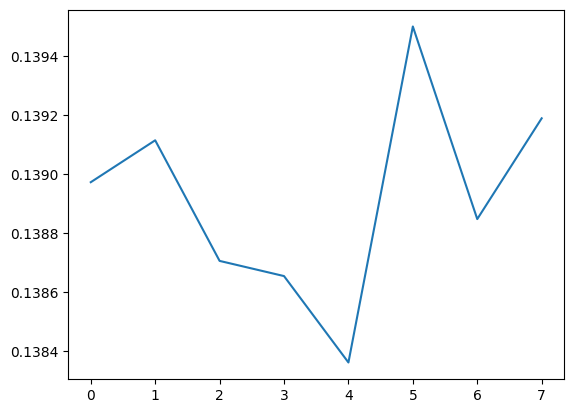

In [ ]:
plt.plot(val_lossi, label='val_loss')